In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os
import fileinput
from pandas_profiling import ProfileReport
import json
import io
import collections
%matplotlib inline

In [2]:
parsed_data = pd.read_csv("output_4_14.csv", sep=",")

In [3]:
len(parsed_data)

1524843

In [4]:
parsed_data.head()

,Unnamed: 0,idx,CWR,ECE,URG,ACK,PSH,RST,SYN,FIN,date_time,SRC
0,0,0,0,0,0,0,0,0,0,0,Apr 07 22:27:58,73.231.179.146
1,1,1,0,0,0,0,0,0,0,0,Apr 07 22:27:59,51.68.32.21
2,2,2,0,0,0,0,0,0,0,0,Apr 07 22:27:59,51.68.32.21
3,3,3,0,0,0,0,0,0,0,0,Apr 07 22:27:59,73.231.179.146
4,4,4,0,0,0,0,0,0,0,0,Apr 07 22:27:59,73.231.179.146


In [5]:
# Get unique count of IP addresses 
df_2 = parsed_data[['SRC', 'date_time']].copy()
df_2.head()
print("There are", len(set(df_2['SRC'])), "unique ip addresses collected in the honeypot")

There are 31138 unique ip addresses collected in the honeypot


# Load Grey Noise Data

31138 unique IP addresses were run through the Grey Noise service to provide background info on IPs 

In [6]:
# Read in grey noise results
#
grey_noise = []
with open('nora-results.txt', 'r',encoding="utf8") as file:
    line = file.readline()
    line = line.replace('}{', '}|{')

    t = line.split('|')
    for e in t:
        if len(e) <=1:
            continue

        d = json.loads(e)
        grey_noise.append(d)
        #print(d)

In [7]:
grey_noise = pd.io.json.json_normalize(grey_noise, errors = 'ignore')
grey_noise.head()                              

,ip,seen,classification,first_seen,last_seen,actor,tags,metadata.country,metadata.country_code,metadata.city,...,metadata.rdns,metadata.asn,metadata.tor,metadata.os,metadata.category,raw_data.scan,raw_data.web.paths,raw_data.web.useragents,raw_data.ja3,error
0,73.231.179.146,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,51.68.32.21,True,malicious,2020-03-17,2020-04-22,unknown,"[Generic IoT Brute Force Attempt, Mirai, Telne...",France,FR,Roubaix,...,thundersbakery.ie,AS16276,False,Linux 3.11+,hosting,"[{'port': 23, 'protocol': 'TCP'}, {'port': 528...",[],[],[],NaN
2,149.56.14.86,True,malicious,2019-12-30,2020-04-21,unknown,"[SSH Bruteforcer, SSH Scanner, SSH Worm]",Canada,CA,Montréal,...,86.ip-149-56-14.net,AS16276,False,unknown,hosting,"[{'port': 22, 'protocol': 'TCP'}, {'port': 78,...",[],[],[],NaN
3,167.71.140.81,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,165.22.203.170,True,unknown,2019-07-28,2020-04-08,unknown,"[DNS Scanner, FTP Scanner, Router RPC Scanner,...",Netherlands,NL,Amsterdam,...,mx.spamhaus.org,AS14061,False,Linux 3.x,hosting,"[{'port': 21, 'protocol': 'TCP'}, {'port': 22,...",[],[],[],NaN


In [8]:
print(list(grey_noise.columns))
grey_noise.head()
print(len(grey_noise))

['ip', 'seen', 'classification', 'first_seen', 'last_seen', 'actor', 'tags', 'metadata.country', 'metadata.country_code', 'metadata.city', 'metadata.organization', 'metadata.rdns', 'metadata.asn', 'metadata.tor', 'metadata.os', 'metadata.category', 'raw_data.scan', 'raw_data.web.paths', 'raw_data.web.useragents', 'raw_data.ja3', 'error']
22791


### Port Scanning Analysis EDA
First we determine how many of our parsed port scans of selected IP addresses have been identified as malicous. 

In [9]:
ip_classification = grey_noise['classification'].value_counts()
ip_classification

unknown      4986
malicious    2622
benign        909
Name: classification, dtype: int64

In [10]:
country_ip  =grey_noise['metadata.country'].value_counts()
print(country_ip) 

print('')
print('ASNs in Data:', '\n')
asn = grey_noise['metadata.asn'].value_counts()
print(asn)


United States    2059
Belgium          2051
China            1082
Germany           367
Netherlands       362
                 ... 
Togo                1
Estonia             1
Aruba               1
Mauritius           1
Afghanistan         1
Name: metadata.country, Length: 115, dtype: int64

ASNs in Data: 

AS33864     2043
AS14061      693
AS51167      278
AS4134       235
AS7922       215
            ... 
AS262851       1
AS15468        1
AS136188       1
AS135607       1
AS14280        1
Name: metadata.asn, Length: 1310, dtype: int64


In [11]:
# Get country and city data
location = grey_noise[['metadata.city', 'metadata.country']].copy()

#drop non-unique locations 
location_unique = location.drop_duplicates()     

In [12]:
# import master world cities list to get location data
master_loc = pd.read_csv("worldcities.csv")

In [13]:
master_loc.head()

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,Tokyo,Tokyo,35.6850,139.7514,Japan,JP,JPN,Tōkyō,primary,35676000.0,1392685764
1,New York,New York,40.6943,-73.9249,United States,US,USA,New York,NaN,19354922.0,1840034016
2,Mexico City,Mexico City,19.4424,-99.1310,Mexico,MX,MEX,Ciudad de México,primary,19028000.0,1484247881
3,Mumbai,Mumbai,19.0170,72.8570,India,IN,IND,Mahārāshtra,admin,18978000.0,1356226629
4,São Paulo,Sao Paulo,-23.5587,-46.6250,Brazil,BR,BRA,São Paulo,admin,18845000.0,1076532519


In [14]:
# merge location and master world cities 
new_loc = pd.merge(location_unique, master_loc, how='left', 
                   left_on=['metadata.city','metadata.country'], right_on=['city','country'])
new_loc.describe(include='all') # We will lose some cities because of they are not major cities

#Drop columns: keep only city, state,and lat long
new_loc = new_loc.drop(columns = ['city', 'city_ascii', 'country', 'iso2', 
                                  'iso3', 'admin_name', 'capital', 'population', 'id'], axis =1)
new_loc.head()

#Merge lat long bacl onto grey_noise data

grey_noise_loc = pd.merge(grey_noise, new_loc, how = 'left', left_on=['metadata.city','metadata.country'], right_on=['metadata.city','metadata.country'] )

In [15]:
print(len(new_loc))
print(len(grey_noise))
print(len(grey_noise_loc))

1945
22791
24319


In [16]:
grey_noise_loc.head()

,ip,seen,classification,first_seen,last_seen,actor,tags,metadata.country,metadata.country_code,metadata.city,...,metadata.tor,metadata.os,metadata.category,raw_data.scan,raw_data.web.paths,raw_data.web.useragents,raw_data.ja3,error,lat,lng
0,73.231.179.146,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,51.68.32.21,True,malicious,2020-03-17,2020-04-22,unknown,"[Generic IoT Brute Force Attempt, Mirai, Telne...",France,FR,Roubaix,...,False,Linux 3.11+,hosting,"[{'port': 23, 'protocol': 'TCP'}, {'port': 528...",[],[],[],NaN,NaN,NaN
2,149.56.14.86,True,malicious,2019-12-30,2020-04-21,unknown,"[SSH Bruteforcer, SSH Scanner, SSH Worm]",Canada,CA,Montréal,...,False,unknown,hosting,"[{'port': 22, 'protocol': 'TCP'}, {'port': 78,...",[],[],[],NaN,45.50,-73.5833
3,167.71.140.81,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,165.22.203.170,True,unknown,2019-07-28,2020-04-08,unknown,"[DNS Scanner, FTP Scanner, Router RPC Scanner,...",Netherlands,NL,Amsterdam,...,False,Linux 3.x,hosting,"[{'port': 21, 'protocol': 'TCP'}, {'port': 22,...",[],[],[],NaN,52.35,4.9166


### Visualization

What can we learn about this port scanning activity? 

Questions to consider: 
1) Where are the port scans coming from? 
2) How many of these scans are malicious?
3) What operating systems are being use? 
4) Look up interesting RDNS (why is an irish bakery considered malicious?
5) Look up interesting ASNs
6) Map (location and time--need another merge so smaller data set) 

Parsed Data Port Scans: 
1) What does the time distrubution look like? (parsed data) 
2) What ports are being scanned? 

#### Port Scan Origins

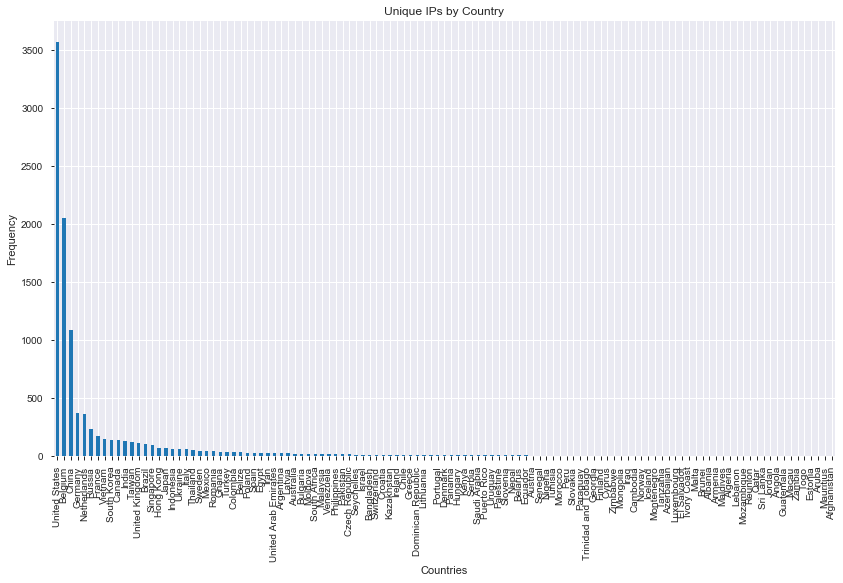

In [29]:
ax = grey_noise_loc['metadata.country'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Unique IPs by Country")
ax.set_xlabel("Countries")
ax.set_ylabel("Frequency")
plt.show()

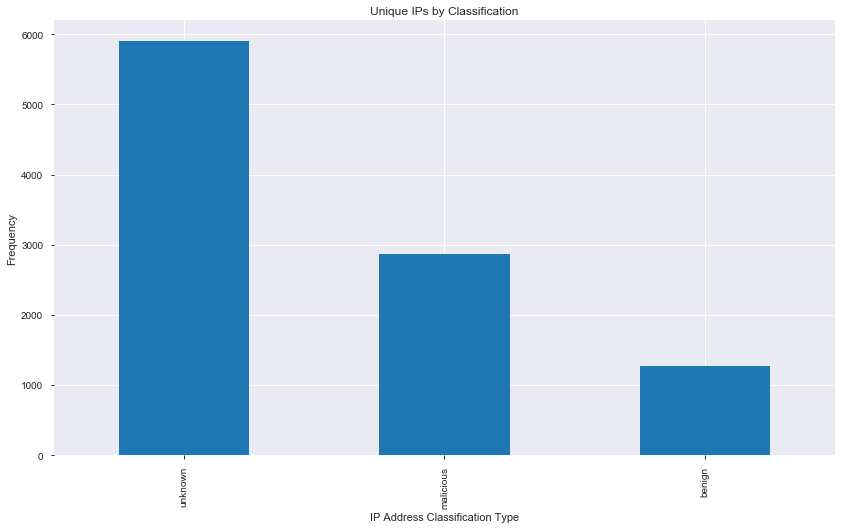

In [30]:
ax = grey_noise_loc['classification'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Unique IPs by Classification")
ax.set_xlabel("IP Address Classification Type")
ax.set_ylabel("Frequency")
plt.show()

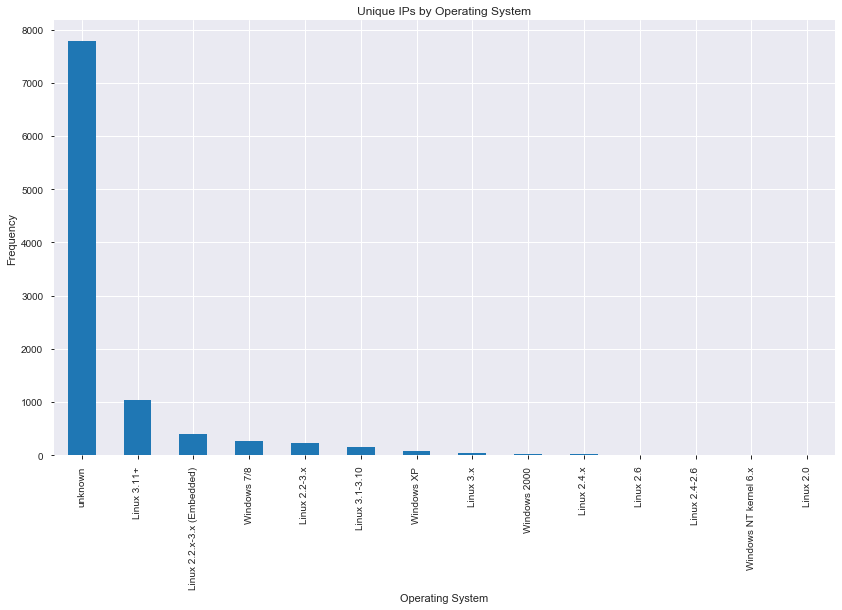

In [36]:
ax = grey_noise_loc['metadata.os'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Unique IPs by Operating System")
ax.set_xlabel("Operating System")
ax.set_ylabel("Frequency")
plt.show()

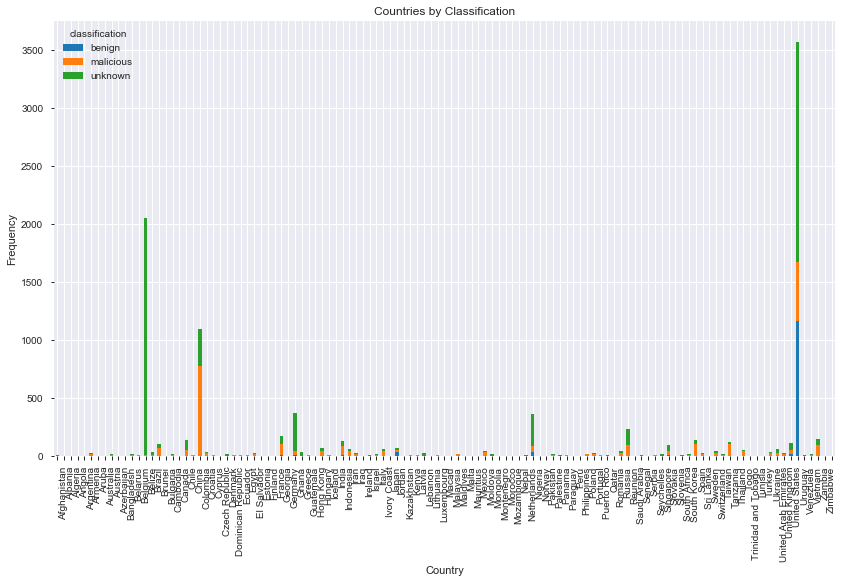

In [47]:
ax = grey_noise_loc.groupby(['metadata.country','classification']).size().unstack().plot(kind='bar',
                                                                                    stacked=True,
                                                                                   figsize=(14,8),
                                                                                   title="Countries by Classification")
ax.set_xlabel("Country")
ax.set_ylabel("Frequency")
plt.show()

In [111]:
# Show names domain names
dns = grey_noise_loc['metadata.rdns']
dns = dns.dropna(axis=0)
dns = list(dict.fromkeys(dns))

for i in dns:
    print(i)


thundersbakery.ie
86.ip-149-56-14.net
mx.spamhaus.org
ec2-54-93-50-35.eu-central-1.compute.amazonaws.com
zg-0312b-251.stretchoid.com
dynamic-ip-adsl.viettel.vn
xx.freeflux.org
do-prod-eu-west-scanner-0402-8.do.binaryedge.ninja
server-185-153-198-240.cloudedic.net
no-reverse-dns-configured.com
registro.lacnic.net
scan-06n.shadowserver.org
50-198-243-206-static.hfc.comcastbusiness.net
ip-112-58.4vendeta.com
ns570281.ip-51-161-12.net
malware-hunter.census.shodan.io
071-067-158-188.biz.spectrum.com
c-50-134-218-103.hsd1.co.comcast.net
scratch-01.sfj.corp.censys.io
113.72.63.218.broad.lc.yn.dynamic.163data.com.cn
scanner21.openportstats.com
160.ip-192-99-152.net
c-50-158-81-186.hsd1.il.comcast.net
190-79-210-16.dyn.dsl.cantv.net
bba590646.alshamil.net.ae
scan049.intrinsec.com
zg-0312c-103.stretchoid.com
196.52.43.61.netsystemsresearch.com
ec2-34-207-73-231.compute-1.amazonaws.com
zg-0312c-457.stretchoid.com
scan-64.security.ipip.net
scanner151.openportstats.com
static-50-53-105-184.bvtn.or.

scan-15b.shadowserver.org
176-87-168-181.fibertel.com.ar
mob-176-244-91-177.net.vodafone.it
zg-0312c-224.stretchoid.com
c-50-166-222-255.hsd1.nj.comcast.net
5-42-116-153.colomna.net
c-50-168-238-92.hsd1.ut.comcast.net
felskowski.com
ns.gz.chinamobile.com
zg-0312c-282.stretchoid.com
c-50-185-242-86.hsd1.ca.comcast.net
66-76-52-81.tyrmcmta02.com.sta.suddenlink.net
bl18-31-29.dsl.telepac.pt
news.presence.pw
116-255-18-115.ip4.superloop.com
220-134-99-62.hinet-ip.hinet.net
bb116-15-199-14.singnet.com.sg
91.98.134.14.pol.ir
zg-0312b-17.stretchoid.com
167.179.95.53.vultr.com
50-54-157-233.evrt.wa.frontiernet.net
scan-70.security.ipip.net
static-66-13-106-202.bdsl.frontiernet.net
cpe-66-67-71-87.twcny.res.rr.com
ec2-50-17-190-75.compute-1.amazonaws.com
host-92-45-199-50.reverse.superonline.net
h-66-166-173-87.chcg.il.globalcapacity.com
static.103.110.203.116.clients.your-server.de
96-72-130-217-static.hfc.comcastbusiness.net
cpe-74-71-157-141.si.res.rr.com
c-50-141-34-63.hsd1.ca.comcast.net
x

191.cust-c00.waldc.net
host-11.230-43-115.dynamic.totalbb.net.tw
ip236.ip-51-254-23.eu
59.cust-d00.waldc.net
074-050-155-232.plateautel.net
142.cust-d00.waldc.net
74.cust-b16.waldc.net
183.cust-b32.waldc.net
88.128-17-84.waldc.net
113.cust-c00.waldc.net
104.cust-c00.waldc.net
228.cust-b32.waldc.net
168.cust-c00.waldc.net
111.cust-d00.waldc.net
172.cust-b32.waldc.net
215.128-17-84.waldc.net
54.cust-b12.waldc.net
mail.joint-power.com.tw
91.128-17-84.waldc.net
alb91-3-78-194-55-101.fbxo.proxad.net
127.128-17-84.waldc.net
89.cust-b16.waldc.net
50.cust-c00.waldc.net
ec2-3-21-125-205.us-east-2.compute.amazonaws.com
63.cust-c00.waldc.net
227.128-17-84.waldc.net
46.128-17-84.waldc.net
zg-0312b-140.stretchoid.com
178.cust-c00.waldc.net
235.cust-b32.waldc.net
104.237.154.148.li.binaryedge.ninja
152.128-17-84.waldc.net
zg-0312b-38.stretchoid.com
12.128-17-84.waldc.net
252.128-17-84.waldc.net
136.128-17-84.waldc.net
smtp.parlement-wallon.be
194.128-17-84.waldc.net
158.128-17-84.waldc.net
99.cust-b

In [112]:
print("There are" ,len(dns), "unique domain names")

There are 4024 unique domain names


In [113]:
# How many of each domain? I expect to see a fair bit of .com, .net, and .be (Belgium)

tld_list = []
for domain in dns: 
    tld = domain.rsplit('.',1)
    tld_end = tld[1]
    tld_list.append(tld_end)


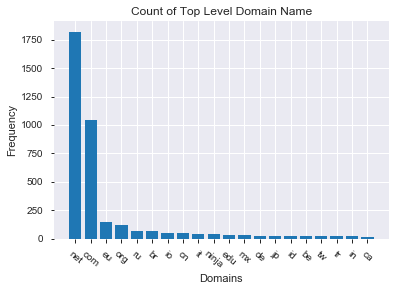

In [125]:
# Get Dict
tld_list_count = collections.Counter(tld_list)
sorted_dict = {k: v for k, v in sorted(tld_list_count.items(), key=lambda item: item[1], reverse=True)}


# PLot
domains = list(sorted_dict.keys())
counts = list(sorted_dict.values())


plt.xlabel('Domains')
plt.ylabel('Frequency')
plt.title("Count of Top Level Domain Name")
plt.xticks(rotation=320)
plt.bar(domains[:20], counts[:20])
plt.show()

As expected, .net and .com are the highest. But this is more .ru than I expected to see and curious what .ninja is. 

In [ ]:
# Show names domain names
dns = grey_noise_loc['metadata.rdns']
dns = dns.dropna(axis=0)
dns = list(dict.fromkeys(dns))

for i in dns:
    print(i)